# Binary Classification

- 0 또는 1의 값으로 output을 하는 모델 생성
- Sigmoid 함수를 사용하는 Logistic Regression 방법으로 Classification하는 모델 생성

In [3]:
%matplotlib inline
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import torch
import torch.nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [4]:
df_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/BreastCancer.csv")
df_raw.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Breast Cancer
- 위스콘신 대 유방암 진단 데이터
- 유방암 데이터로 악성, 양성 판단하는 모델 만들기

[변수 설명]
- ID: 환자 식별 번호
- diagnosis: 양성 여부(M=악성, B=양성)
- radius: 반경(중심에서 외벽까지 거리틀의 평균값)
- texture: 질감(Gray-Sacle 값들의 표준편차)
- perimeter: 둘레
- area: 면적
- smoothness: 매끄러움(반경길이의 국소적 변화)
- compactness: 조그만 정도
- concavity: 오목함
- points: 오목한 점의 수
- symmetry: 대칭
- dimension: 프렉탈 차원
- _mean(10): 항목별 평균값
- _se(10): 항목별 표준오차
- _worst(10): 가장 큰 3개 값의 평균

# 1. 데이터 전처리

In [6]:
# 불필요한 Feature Column 삭제

x = df_raw.drop(columns = ['id','Unnamed: 32'], axis=1)

x = x.drop(['diagnosis'], axis=1)

diag = {'M':1, 'B':0}
y = df_raw['diagnosis'].replace(diag)

print(x.shape)
print(y.shape)

(569, 30)
(569,)


In [10]:
# 학습데이터와 테스트데이터를 일정비율로 나누기
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=85)

print("x_train의 크기: {}".format(x_train.shape))
print("y_train의 크기: {}".format(y_train.shape))

print("x_test의 크기: {}".format(x_test.shape))
print("y_test의 크기: {}".format(y_test.shape))

x_train의 크기: (455, 30)
y_train의 크기: (455,)
x_test의 크기: (114, 30)
y_test의 크기: (114,)


In [12]:
# 학습데이터 scaling
scaler = StandardScaler()
scaler.fit(x_train)
x_train_tran = scaler.transform(x_train)

# 학습 데이터 배치화 시키기
train_data = data_utils.TensorDataset(torch.FloatTensor(x_train_tran),
                                      torch.FloatTensor(y_train.values))

dataloader = data_utils.DataLoader(train_data, batch_size=128, shuffle=False)

# 배치화된 데이터 확인
for batch_idx, datas in enumerate(dataloader):
  print(batch_idx)
  print(datas[0].shape)
  print(datas[1].shape)

# 테스트데이터 scaling
x_test_tran = scaler.transform(x_test)

# 테스트 데이터 텐서로 변환
x_test_tensor = torch.FloatTensor(x_test_tran)
y_test_tensor = torch.FloatTensor(y_test.values)

0
torch.Size([128, 30])
torch.Size([128])
1
torch.Size([128, 30])
torch.Size([128])
2
torch.Size([128, 30])
torch.Size([128])
3
torch.Size([71, 30])
torch.Size([71])


# 2. Model

$$ H(X) = \frac{1}{1+e^{-W^T X}} $$

In [26]:
class LogisticRegression(torch.nn.Module):
        def __init__(self, input_size, output_size):
            super(LogisticRegression, self).__init__()
            self.input_size = input_size
            self.output_size = output_size
            self.linear = torch.nn.Linear(self.input_size, self.output_size)
            self.sigmoid = torch.nn.Sigmoid()
            
        def forward(self, input_tensor):
            linear1 = self.linear(input_tensor)
            output = self.sigmoid(linear1)
            return output

$$ cost(W) = -\frac{1}{m} \sum y \log\left(H(x)\right) + (1-y) \left( \log(1-H(x) \right) $$

In [27]:
# Hyper-Parameter
input_size = 30
output_size = 1
learning_rate = 0.01
n_epochs = 200

# model 생성
model = LogisticRegression(input_size=input_size, output_size=output_size)

## 손실함수 생성
criterion = torch.nn.BCELoss() # 내부적으로 softmax 함수가 적용

# Opitmizer 생성
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 3. Training
- 분류에서는 성능 지표로 Accuracy 사용
- Accuracy(정확도) = 정답수/전체 예측 횟수

In [28]:
## Running the model
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(n_epochs+1):
  for idx, (x_batch, y_batch) in enumerate(dataloader):
    model.train()

    optimizer.zero_grad()

    y_pred = model(x_batch)
    y_pred = y_pred.reshape(-1)

    loss_train = criterion(y_pred.squeeze(), y_batch)

    # 정답을 맞춘 예측값을 카운트
    # sigmoid 값에서 나왔기 때문에 0에서 1 사이의 값 반환
    prediction = [1 if x>0.5 else 0 for x in y_pred.data.numpy()]
    correct = (prediction == y_batch.numpy()).sum()

    loss_train.backward()
    optimizer.step()

    # validation
    model.eval()
    
    y_test_pred = model(x_test_tensor)
    loss_test = criterion(y_test_pred.squeeze(), y_test_tensor)
    
    prediction_test = [1 if x>0.5 else 0 for x in y_test_pred.data.numpy()]
    correct_test = (prediction_test == y_test_tensor.data.numpy()).sum()
  
  accuracy_train = (100*correct/len(prediction))
  accuracy_test = (100*correct_test/len(prediction_test))

  train_loss.append(loss_train.data)
  test_loss.append(loss_test.data)
  train_accuracy.append(accuracy_train)
  test_accuracy.append(accuracy_test)
  print(f'epoch: {epoch}, Loss_train: {train_loss[-1]: .2f}, Accuracy_train: {train_accuracy[-1]: .2f}, Loss_test{test_loss[-1]:.2f}, Accuracy_test: {test_accuracy[-1]: .2f}')

epoch: 0, Loss_train:  0.69, Accuracy_train:  60.56, Loss_test0.68, Accuracy_test:  54.39
epoch: 1, Loss_train:  0.61, Accuracy_train:  74.65, Loss_test0.61, Accuracy_test:  74.56
epoch: 2, Loss_train:  0.55, Accuracy_train:  84.51, Loss_test0.55, Accuracy_test:  85.09
epoch: 3, Loss_train:  0.50, Accuracy_train:  91.55, Loss_test0.51, Accuracy_test:  88.60
epoch: 4, Loss_train:  0.46, Accuracy_train:  95.77, Loss_test0.47, Accuracy_test:  89.47
epoch: 5, Loss_train:  0.43, Accuracy_train:  97.18, Loss_test0.44, Accuracy_test:  89.47
epoch: 6, Loss_train:  0.40, Accuracy_train:  97.18, Loss_test0.41, Accuracy_test:  91.23
epoch: 7, Loss_train:  0.38, Accuracy_train:  97.18, Loss_test0.39, Accuracy_test:  92.11
epoch: 8, Loss_train:  0.36, Accuracy_train:  97.18, Loss_test0.37, Accuracy_test:  92.11
epoch: 9, Loss_train:  0.34, Accuracy_train:  97.18, Loss_test0.36, Accuracy_test:  92.11
epoch: 10, Loss_train:  0.33, Accuracy_train:  97.18, Loss_test0.34, Accuracy_test:  93.86
epoch: 11

- nn.Module에서는 train time과 evaluate time에 수행하는 다른 작업을 switching 해줄 수 있도록하는 함수 제공

- train time과 evaluate time에 서로 다르게 동작해야 하는 것들에는 대표적으로 아래와 같은 것들이 있음
  - Dropout layer
  - BatchNorm layer

- model.train() : 모델을 학습 모드로 변환
- model.eval(): 모델을 평가 모드로 변환

- data,target = data.to(DEVICE), target.to(DEVICE) : 각 data와 target을 앞서 설정한 DEVICE(GPU 혹은 CPU)에 보내는 것

- optimizer.zero_grad(): 반복 때마다 기울기를 새로 계산하므로, 이 함수를 초기화

- output = model(data): data를 모델에 넣어서 가설(hypothesis) 획득

- loss = F.cross_entropy(output, target): 가설과 groud truth를 비교하여 loss 계산

- loss.backward(): loss를 역전파 알고리즘으로 계산

- optimizer.step(): 계산한 기울기를 앞서 정의한 알고리즘에 맞추어 가중치 수정

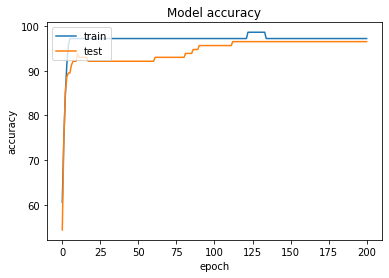

In [29]:
plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.title("Model accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

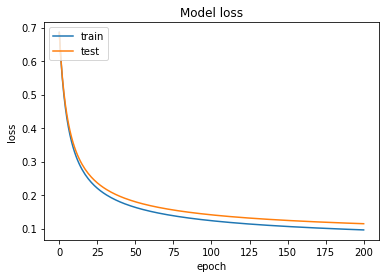

In [30]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.title("Model loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()